# I/O

Typically when doing data analysis you want to read and write data from various file formats. In this exercise session we'll go through some common file formats
- Basic Python I/O
- Numpy txt I/O
- Pandas CSV I/O
- Pandas SQL I/O

## Basic Python I/O

The basic python I/O is useful if you have some file in some custom format and you need to do some manual processing of it as part of creating whatever in-memory datastructure you need. To start with, lets create a file to play around with:

In [5]:
with open('pangrams.txt', 'w') as f:
    f.write("""The quick brown fox jumps over the lazy dog
Sphinx of black quartz, judge my vow
The dog ate my homework
Pack my box with five dozen liquor jugs
""")

You might be wondering, why the "with" thing instead of just

In [10]:
f = open('pangrams.txt')

In python, a "with"-block ensures that resources declared are released when exiting the block. In this case it means that when we exit the block the file will be closed. So we don't have to close it explicitly (also: exception-safety!).

Classes which implement the so-called "context-manager" protocol can be used in with-statements.

A pangram is a sentence which contains all the characters in the alphabet. In the file we just created we have one pangram per row. Or are they actually pangrams?

**Exercise**: Read the file pangrams.txt we just created, and write a snippet to check whether each pangram is, in fact, a pangram (i.e. does it use every letter in the English alphabet?).

In [6]:
with open('pangrams.txt') as f:
    alph = 'abcdefghijklmnopqrstuvxyz'
    print('Pangram    Sentence')
    print('===================================================')
    for line in f:
        pangram = True
        for c in alph:
            if not c in line.lower():
                pangram = False
                break
        print('%-10s %s' % (pangram, line.strip()))

Pangram    Sentence
True       The quick brown fox jumps over the lazy dog
True       Sphinx of black quartz, judge my vow
False      The dog ate my homework
True       Pack my box with five dozen liquor jugs


## Web (HTTP) I/O

It's fairly straightforward to read from a website as well. e.g.

In [7]:
import urllib.request

with urllib.request.urlopen('https://www.gutenberg.org/files/219/219-0.txt') as f:
    data = f.read()
print((len(data))) # Or whatever you want to do with it

234041


**Exercise**: Use the various string methods and/or regular expressions to retrieve the author and title of the document we just downloaded from the Gutenberg project. **Hint** : That information can be found as lines with "Author: XXXX" and "Title: YYYY" in the data.

In [26]:
s = data.decode('utf-8')
authfound = False
titlefound = False
for line in iter(s.splitlines()):
    if not authfound and line.startswith('Author:'):
        print(line)
        authfound = True
    elif not titlefound and line.startswith('Title:'):
        print(line)
        titlefound = True
    if authfound and titlefound:
        break

Title: Heart of Darkness
Author: Joseph Conrad


## Numpy I/O

Numpy provides some basic routines which can be useful if you need to load data to/from a Numpy ndarray. For reading/writing textfiles there is ``loadtxt`` and ``savetxt``. See also ``genfromtxt`` with more sophisticated handling of missing values etc.

In [5]:
import numpy as np
from io import StringIO

In [6]:
np.loadtxt(StringIO("1 2 3\n4 5 6"))

array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.]])

For binary IO of Numpy ndarrays defines a so-called ``.npy`` format. Reading/writing these files can be done with the ``load`` and ``save`` methods. There's also the ``.npz`` format, which is a zip archive containing several numpy ndarrays in one file. ``.npz`` format files can be read/written with ``load``, ``savez`` and ``savez_compressed`` methods. This is a good choice for temporary or intermediate files such as checkpoints etc. Note that the format is Numpy-specific, and other languages might not easily be able to read it. Similarly, for long-term archiving other formats might be a better choice.

## Pandas I/O

For dataframes, "natural" file formats are things that support tabular data, like CSV files and RDBMS ("SQL databases"). Pandas provides the ``read_csv`` function for reading CSV files (see also other pandas ``read_*`` functions). Similarly, for writinig data there is ``to_csv`` as well as other ``to_*`` functions.

For binary I/O, Pandas supports a bunch of them. As was mentioned in the R sessions, the ``feather`` format is a fast binary format supported by both Pandas and R, so if you need intermediate files and/or interoperability with R, that is a good choice.

Pandas also provides some convenience functions for doing SQL queries and reading the data directly into a Pandas dataframe.

In [10]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("test.sq3")
c = conn.cursor()
c.execute('''create table if not exists test (date integer primary key, alloc integer not null, total integer not null)''')
conn.commit()
c.close()

In [11]:
import os.path
d = pd.read_csv(os.path.join(pd.__path__[0], 'tests/data/iris.csv'), dtype={'Name': 'category'})
d.to_sql('iris', conn)

In [12]:
d2 = pd.read_sql_query('select * from iris', conn)

**Exercise**: The file data/nvutil.sq3 contains an SQLite database with utilization data for the Triton GPU nodes over a time interval. Read that data into a Pandas dataframe, and plot the utilization as a function of time. **Hint** Open a shell, use the ``sqlite3`` command to open the database, then you can use the ``.tables`` command to list the tables in the DB, and ``.schema TABLENAME`` to view the schema of a table. Also note that sq SQLite does not have any native datetime datatype, data in the date column is stored as seconds since the epoch (1970-01-01T00:00).

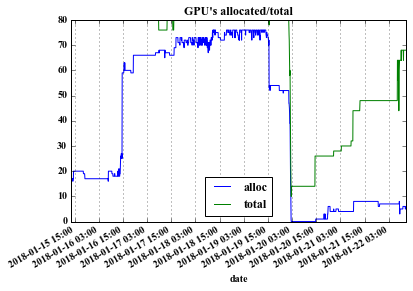

In [20]:
%matplotlib inline
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("data/nvutil.sq3")
df = pd.read_sql_query("SELECT * from nvutil", con, parse_dates={'date': {'unit': 's'}}, index_col='date')
con.close()

# Convert the date column from unix timestamps to pandas timestamps
#df['date'] = pd.to_datetime(df['date'], unit='s')

# verify that result of SQL query is stored in the dataframe
#print(df.head(), df.tail())

fig, ax = plt.subplots(1)
#fig = plt.figure()
fig.autofmt_xdate()
import matplotlib.dates as mdates

df.plot(title="GPU's allocated/total", ax=ax)
ax.set_xticks([])
ax.set_xticks([], minor=True)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H:%M')
ax.xaxis.grid(True, which="major")
#plt.xticks(rotation='vertical', fontsize = 8)
#plt.savefig('nvutil.svg')
plt.show()
